In [2]:
import sys
from pathlib import Path
import os
import voyageai
from dotenv import load_dotenv
sys.path.append(os.path.join(Path.cwd().parent, 'src')) 
sys.path.append(os.path.join(Path.cwd().parent, 'src', 'util')) 

load_dotenv()  # This loads the variables from .env
VOYAGE_API_KEY = os.getenv('VOYAGE_API_KEY')
client = voyageai.Client(api_key=VOYAGE_API_KEY)

## Data Processing

In [ ]:
script_dir = os.path.dirname(os.path.abspath(__file__))
src_dir = os.path.join(script_dir, 'src')
utils_dir = os.path.join(src_dir, 'utils')
sys.path.append(src_dir)
sys.path.append(utils_dir)

from utils import load_data, json_arr_to_file, run_api_call
from utils import  intention_prompt_first, intention_prompt_second , preprocess_options_and_labels, intention_prompt_second_llama
from utils import call_llama 

In [22]:
import json

def process_json(json_data):
    # Load JSON data
    data = json_data
    
    # Extract 'topic', 'scenario', and 'options'
    topic = data['topic']
    scenario = data['scenario']
    first_period_index = scenario.find('.')
    if first_period_index != -1:
        # 从第一个句号的位置开始截取字符串
        scenario = scenario[:first_period_index + 1]
    options = [option.replace("Suggest that the user", "") for option in data['options']]
    
    # Concatenate 'topic', 'scenario', and 'options'
    concatenated_text = topic + "." + scenario + ".".join(options)
    
    return concatenated_text

# Process the JSON data
result = process_json(json_data)
print(result)


Technology Use.I can't connect my printer to my computer. checks the printer's connection and drivers. restarts both the printer and the computer. takes a break and tries again later. throws the printer out the window. hits the printer


In [ ]:
def embed_one_file(file , write_path , max_tokens, model  ):
    """
    Function to process one file in the dataset directory
    Inputs:
    file: str, path to the file to process
    write_path: str, path to the desired output file 
    """
    full_json = load_data(file)
    for item in full_json: 
        op = item['options']
        lab  = item['labels']
        scenario = item['scenario']
        
        mapping, pr_string  = preprocess_options_and_labels(op, lab, adapt_outcome)
        item['mapping_given_to_model'] = mapping 

        first_prompt = intention_prompt_first(scenario, pr_string)

    print(f'Starting to save file {file}')
    json_arr_to_file(full_json, write_path, indent=4)
    print('File saved. \n')

In [23]:
batch_size = 128
embeddings = []
for i in range(0, len(combine), batch_size):
    embeddings += vo.embed(combine[i:i + batch_size], model="voyage-large-2", input_type="document").embeddings

In [47]:
combine = pd.DataFrame(combine)
combine['v_embedding'] = embeddings

In [57]:
df = pd.DataFrame({'embeddings': embeddings})

In [52]:
combine.to_excel("../data/embed.xlsx")

## K-Means

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score

In [69]:
combine['v_embedding'] = combine['v_embedding'].apply(np.array)

In [80]:
def calculate_silhouette_scores(data_matrix, min_clusters=3, max_clusters=15):
    cluster_results_km = pd.DataFrame(columns=['k', 'score'])
    
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        silhouette = silhouette_score(data_matrix, y)
        dic = {'k': [k], 'score': [silhouette]}
        cluster_results_km = pd.concat([cluster_results_km, pd.DataFrame(dic)])    
    return cluster_results_km

def find_optimal_cluster(cluster_results):
    cluster_results = cluster_results.reset_index(drop=True)
    optimal_cluster = cluster_results['score'].idxmax()
    optimal_cluster = cluster_results['k'].iloc[optimal_cluster]
    return optimal_cluster

In [81]:
matrix = np.vstack(combine['v_embedding'])
cluster_results_km = calculate_silhouette_scores(matrix)
num_cluster = find_optimal_cluster(cluster_results_km)

print("Optimal number of clusters:", num_cluster)
print(cluster_results_km.loc[cluster_results_km['k'] == num_cluster])

  0%|          | 0/13 [00:00<?, ?it/s]

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_17593/2306006225.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_results_km=pd.concat([cluster_results_km, pd.DataFrame(dic)])
/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yangzejia/anaconda3/envs/te

Optimal number of clusters: 3
   k     score
0  3  0.031817


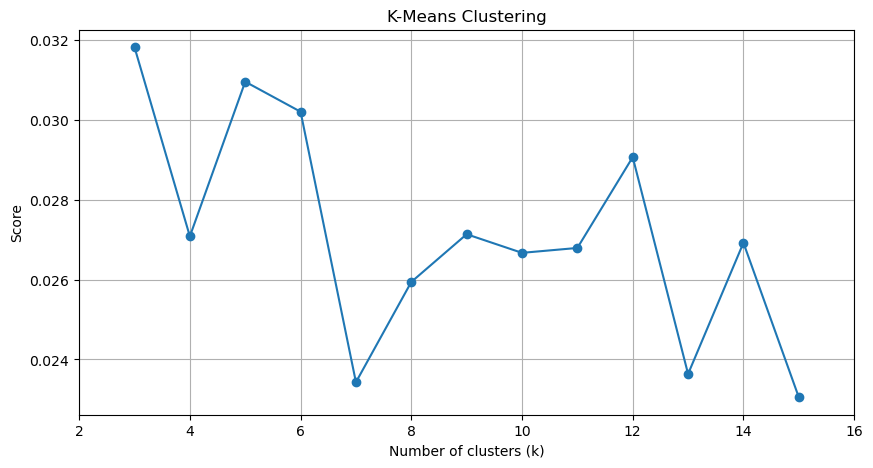

In [85]:
# Assuming cluster_results_km['k'] and cluster_results_km['score'] are your data
plt.figure(figsize=(10, 5))
plt.plot(cluster_results_km['k'], cluster_results_km['score'], marker='o', linestyle='-')
plt.xlim(2, 16)
# Add title and labels
plt.title('K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

# Add grid
plt.grid(True)

# Show plot
plt.show()

In [99]:
num_cluster = 5
km_model = KMeans(n_clusters = num_cluster, init ='k-means++', random_state = 42)
y = km_model.fit_predict(matrix)
combine[f'{num_cluster}_Cluster']=y

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [100]:
combine

,0,v_embedding,Cluster,3_Cluster,5_Cluster
0,Does entrepreneurship education in the first y...,"[-0.008451409637928009, 0.0033586297649890184,...",0,1,0
1,Adapting to constructivist approaches to entre...,"[0.014256583526730537, 0.004288913682103157, 0...",4,0,4
2,Active entrepreneurship education and the impa...,"[0.009077167138457298, 0.02005642093718052, 0....",4,0,4
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.01472783088684082, 0.01929645612835884, 0....",0,1,0
4,Developing entrepreneurial behaviours in the C...,"[-0.00040966836968436837, -0.00694393552839756...",4,0,4
...,...,...,...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.0062180496752262115, 0.0036392933689057827...",1,1,1
448,What's new in the research on agricultural ent...,"[-0.011482832953333855, 0.0021173979621380568,...",0,1,0
449,Towards a more integrated view of entrepreneur...,"[-0.019980620592832565, 0.019933383911848068, ...",0,0,0
450,The formation of youth entrepreneurial intenti...,"[-0.009015019983053207, 0.025102421641349792, ...",0,1,0


### Visualization With k = 5?

Text(0, 0.5, 'Axis 2')

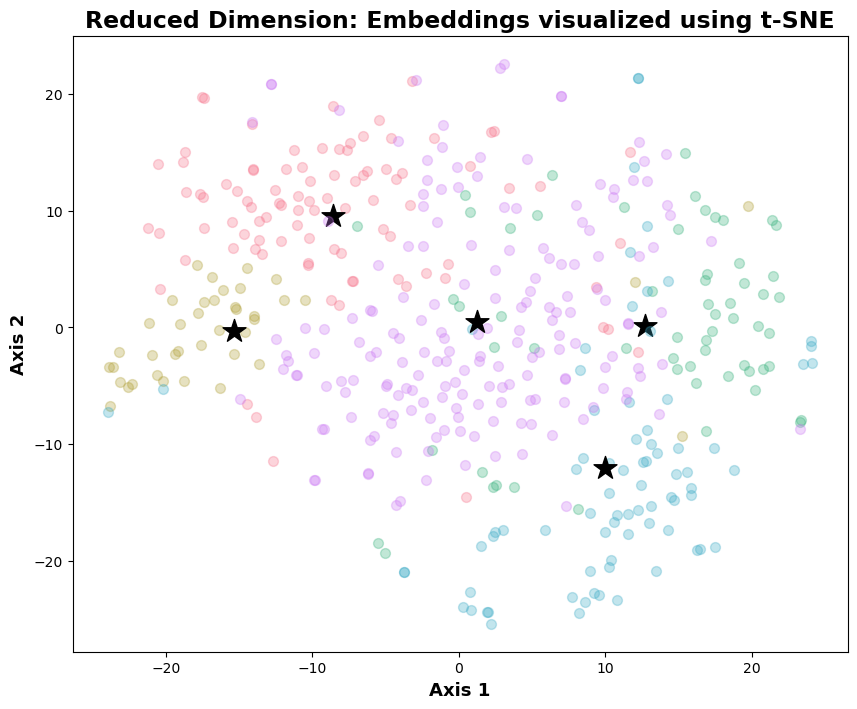

In [104]:
plt.rcParams['figure.figsize'] = (10, 8) 

#tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
tsne = TSNE(n_components=2)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[combine[f'{num_cluster}_Cluster']==category]
    ys = np.array(y)[combine[f'{num_cluster}_Cluster']==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)
plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")

Text(0, 0.5, 'Axis 2')

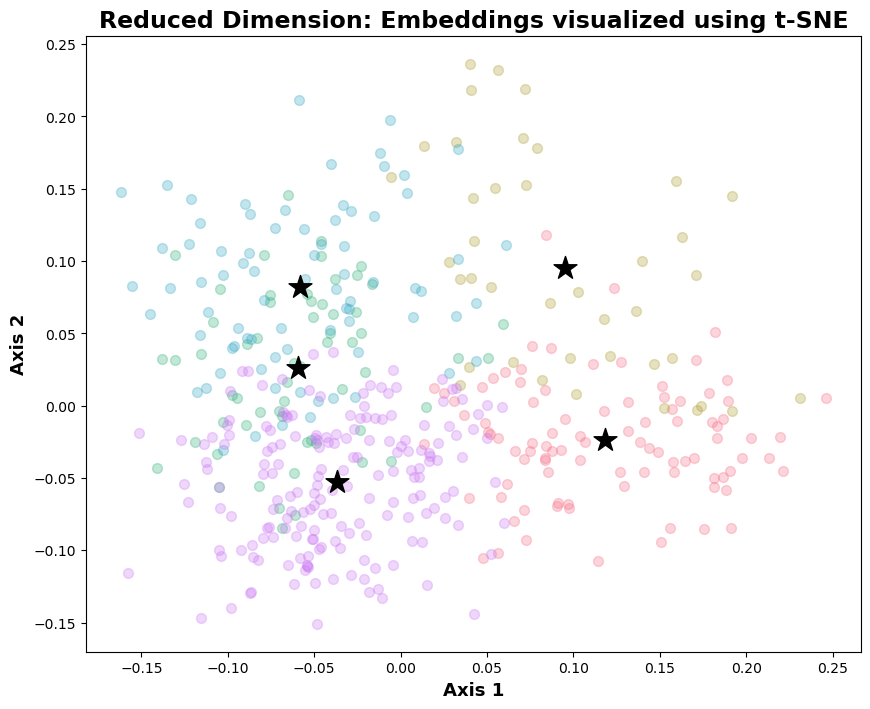

In [101]:
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (10, 8) 

pca = PCA(n_components=2)
vis_dims2 = pca.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[combine[f'{num_cluster}_Cluster']==category]
    ys = np.array(y)[combine[f'{num_cluster}_Cluster']==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)
plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")

In [105]:
combine

,0,v_embedding,Cluster,3_Cluster,5_Cluster
0,Does entrepreneurship education in the first y...,"[-0.008451409637928009, 0.0033586297649890184,...",0,1,0
1,Adapting to constructivist approaches to entre...,"[0.014256583526730537, 0.004288913682103157, 0...",4,0,4
2,Active entrepreneurship education and the impa...,"[0.009077167138457298, 0.02005642093718052, 0....",4,0,4
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.01472783088684082, 0.01929645612835884, 0....",0,1,0
4,Developing entrepreneurial behaviours in the C...,"[-0.00040966836968436837, -0.00694393552839756...",4,0,4
...,...,...,...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.0062180496752262115, 0.0036392933689057827...",1,1,1
448,What's new in the research on agricultural ent...,"[-0.011482832953333855, 0.0021173979621380568,...",0,1,0
449,Towards a more integrated view of entrepreneur...,"[-0.019980620592832565, 0.019933383911848068, ...",0,0,0
450,The formation of youth entrepreneurial intenti...,"[-0.009015019983053207, 0.025102421641349792, ...",0,1,0


In [108]:
label = combine.drop(['v_embedding', 'Cluster', '3_Cluster'], axis=1)

In [118]:
label.rename(columns={0: "Abstract"}, inplace=True)
label

,Abstract,5_Cluster
0,Does entrepreneurship education in the first y...,0
1,Adapting to constructivist approaches to entre...,4
2,Active entrepreneurship education and the impa...,4
3,Nurturing Entrepreneurial Spirit Through Integ...,0
4,Developing entrepreneurial behaviours in the C...,4
...,...,...
447,The effect of entrepreneur mentoring and its d...,1
448,What's new in the research on agricultural ent...,0
449,Towards a more integrated view of entrepreneur...,0
450,The formation of youth entrepreneurial intenti...,0


In [151]:
raw = pd.read_excel("../data/d.xls")
result = pd.merge(raw, label, left_index=True, right_index=True)
result.drop(['Abstract_y', 'Publication Type'], inplace=True, axis=1)
result.sort_values(by='5_Cluster', inplace=True)
result.reset_index(inplace=True, drop=True)
result.to_excel("5_cluster.xlsx")